# Download the Dataset

In [0]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip

--2019-12-11 20:36:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  27.7MB/s    in 2.4s    

2019-12-11 20:36:47 (27.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



# Import the Packages

In [0]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline

# Extract the Images Dataset

In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Setup the Images Directories

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Configure the Inception V3 Model

## Download the weights of the Model

In [0]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-12-11 20:36:53--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  69.2MB/s    in 1.2s    

2019-12-11 20:36:54 (69.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



## Configure the Inception V3 Model

In [0]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
pre_trained_model.load_weights(local_weights_file)

In [0]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
# Freeze the Layers
for layer in pre_trained_model.layers:
  layer.trainable = False

In [0]:
# Retrieve the last layer
last_layer = pre_trained_model.get_layer(name='mixed7')
print('Last Layer Output Shape: ', last_layer.output_shape)

Last Layer Output Shape:  (None, 7, 7, 768)


In [0]:
# Output of the last layer
last_output = last_layer.output

## Setup the Model

In [0]:
x = layers.Flatten()(last_output)

x = layers.Dense(units=1024, activation='relu')(x)

x = layers.Dropout(rate=0.2)(x)

x = layers.Dense(units=1, activation='sigmoid')(x)

In [0]:
model = Model(pre_trained_model.input, x)

In [0]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Configure the ImageDataGenerator

In [0]:
train_datagen = ImageDataGenerator(rescale=1/255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)

In [0]:
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

test_generator = test_datagen.flow_from_directory(directory=validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Train the model

In [0]:
history = model.fit_generator(generator=train_generator, steps_per_epoch=100, epochs=20, validation_data=test_generator, validation_steps=50, verbose=1)

Epoch 1/20
100/100 [==============================] - 28s 285ms/step - loss: 0.5167 - acc: 0.7400 - val_loss: 0.2385 - val_acc: 0.9280
Epoch 2/20
100/100 [==============================] - 23s 227ms/step - loss: 0.3869 - acc: 0.8170 - val_loss: 0.2047 - val_acc: 0.9470
Epoch 3/20
100/100 [==============================] - 23s 229ms/step - loss: 0.3384 - acc: 0.8555 - val_loss: 0.3632 - val_acc: 0.9210
Epoch 4/20
100/100 [==============================] - 23s 228ms/step - loss: 0.3199 - acc: 0.8660 - val_loss: 0.4668 - val_acc: 0.9220
Epoch 5/20
100/100 [==============================] - 23s 227ms/step - loss: 0.3354 - acc: 0.8575 - val_loss: 0.3892 - val_acc: 0.9370
Epoch 6/20
100/100 [==============================] - 22s 224ms/step - loss: 0.3107 - acc: 0.8780 - val_loss: 0.2792 - val_acc: 0.9500
Epoch 7/20
100/100 [==============================] - 23s 229ms/step - loss: 0.2882 - acc: 0.8850 - val_loss: 0.2945 - val_acc: 0.9550
Epoch 8/20
100/100 [==============================] - 2

# Evaluating Accuracy and Loss

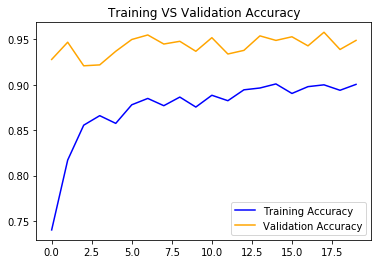

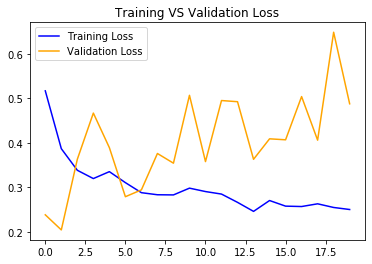

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation Accuracy')
plt.title('Training VS Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='orange', label='Validation Loss')
plt.title('Training VS Validation Loss')
plt.legend()
plt.show()

# Test the model on new images [Use google colab]

In [0]:
class_names = ['Cat', 'Dog']

<b>Note</b> : <i>You might have to run the below cell twice.</i>

Saving dog_5.jpeg to dog_5 (1).jpeg


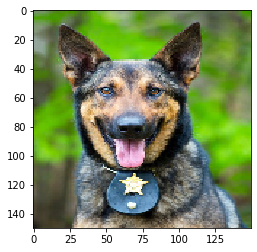

Prediction: Dog


In [0]:
uploaded = files.upload()

for file_name in uploaded.keys():

  path = file_name

  img = image.load_img(path, target_size=(150, 150))

  x = image.img_to_array(img)

  x = np.expand_dims(x, axis=0)

  x /= 255.

  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  plt.imshow(img)
  plt.grid(False)
  plt.show()

  if classes[0][0] > 0.6:
    print('Prediction: {}'.format(class_names[1]))
  else:
    print('Prediction: {}'.format(class_names[0]))

# Save the model

In [0]:
export_dir = "./saved_model_v1"
tf.saved_model.save(model, export_dir)

# Create a zip file to download the model locally

In [0]:
shutil.make_archive(base_name="saved_model_v1",format="zip",root_dir="saved_model_v1")

'/content/saved_model_v1.zip'

# Load the saved model


In [0]:
keras_model = tf.keras.models.load_model(export_dir)

Saving dog_4.jpeg to dog_4 (4).jpeg


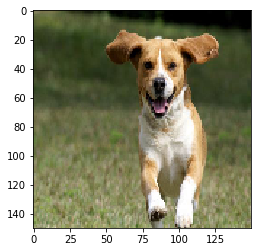

Prediction: Dog


In [0]:
uploaded = files.upload()

for file_name in uploaded.keys():

  path = file_name

  img = image.load_img(path, target_size=(150, 150))

  x = image.img_to_array(img)

  x = np.expand_dims(x, axis=0)

  x /= 255.

  images = np.vstack([x])

  classes = keras_model.predict(images, batch_size=10)

  plt.imshow(img)
  plt.grid(False)
  plt.show()

  if classes[0][0] > 0.6:
    print('Prediction: {}'.format(class_names[1]))
  else:
    print('Prediction: {}'.format(class_names[0]))